In [3]:
import cmasher as cmr
import geopandas as gpd
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import os
import pandas as pd

## Load in data and shapefiles

### Load in census shapefiles

In [4]:
# - Load census block groups
cbgs = gpd.read_file('/opt/laurelhurst4all/data/shapefiles/Census_Block_Groups_2010/Census_Block_Groups_2010.shp')
cbgs = cbgs[['GEOID10','geometry']]
cbgs.rename(columns={'GEOID10':'fips'}, inplace=True)
cbgs['fips'] = pd.to_numeric(cbgs['fips'])
cbgs['geometry'] = cbgs['geometry'].to_crs(epsg=4326)

In [5]:
# - Load census tracts
cts = gpd.read_file('/opt/laurelhurst4all/data/shapefiles/Census_Tracts_2010/Census_Tracts_2010.shp')
cts = cts[['GEOID10','geometry']]
cts.rename(columns={'GEOID10':'fips'}, inplace=True)
cts['fips'] = pd.to_numeric(cts['fips'])
cts['geometry'] = cts['geometry'].to_crs(epsg=4326)

In [6]:
# - Load census blocks
cbs = gpd.read_file('/opt/laurelhurst4all/data/shapefiles/2010_Census_Blocks/2010_Census_Blocks.shp')
cbs = cbs[['GEOID10','geometry']]
cbs.rename(columns={'GEOID10':'fips'}, inplace=True)
cbs['fips'] = pd.to_numeric(cbs['fips'])
cbs['geometry'] = cbs['geometry'].to_crs(epsg=4326)

### Load in city boundary shapefile

In [7]:
citybdrs = gpd.read_file('/opt/laurelhurst4all/data/shapefiles/Municipal_Boundaries/Municipal_Boundaries.shp')
citybdrs['geometry'] = citybdrs['geometry'].to_crs(epsg=4326)
#print(citybdrs.head())
seabdr = citybdrs[citybdrs['CITYNAME'] == 'Seattle']
#seabdr.plot()

### Load in roads shapefile

In [8]:
majrds = gpd.read_file('/opt/laurelhurst4all/data/shapefiles/roads500k/sr500k_20201231.shp')
majrds['geometry'] = majrds['geometry'].to_crs(epsg=4326)
#print(majrds.head())
majrds = majrds[(majrds['StateRoute']=='405')|(majrds['StateRoute']=='005')
                |(majrds['StateRoute']=='522')|(majrds['StateRoute']=='520')
                |(majrds['StateRoute']=='527')|(majrds['StateRoute']=='90')]
#majrds.plot()

### Load in more detailed roads shapefile

In [9]:
seards = gpd.read_file('/opt/laurelhurst4all/data/shapefiles/2018_Traffic_Flow_Counts-shp/2018_Traffic_Flow_Counts.shp')
seards['geometry'] = seards['geometry'].to_crs(epsg=4326)
#print(seards.head())
allseards = seards
seards = seards[seards['AWDT_ROUND']>=20000]
#Average Weekday Traffic: derived by averaging
#24-hour daily traffic volumes for both directions
#across Monday thru Friday, excluding holidays
#and weekends, then adjusting for seasonal
#variations by applying an annual adjustment
#factor. This number is given in thousands of
#vehicles.
#seards.plot()

### Load in water shapefiles

In [10]:
majwater = gpd.read_file('/opt/laurelhurst4all/data/shapefiles/water/Open_water_for_King_County_and_portions_of_adjacent_counties___wtrbdy_area.shp')
#print(majwater.crs)
#print(majwater.head())
majwater = majwater[(majwater['NAME']=='Green Lake')
                    |(majwater['NAME']=='Lake Union')
                    |(majwater['NAME']=='Salmon Bay')
                    |(majwater['NAME']=='Lake Washington')
                    |(majwater['NAME']=='Puget Sound')
                    |(majwater['NAME']=='Duwamish River')]
#majwater.plot()

### Load in redlining map

In [11]:
rl = gpd.read_file('/opt/laurelhurst4all/data/shapefiles/WASeattle1936/cartodb-query.shp')
#print(rl.crs)
#print(rl.head())
#rl.plot(column='holc_grade')
rl = rl[['holc_grade', 'geometry']]

In [12]:
rl_conditions0 = [
    (rl['holc_grade'] == 'A') | (rl['holc_grade'] == 'B'),
    (rl['holc_grade'] == 'C') | (rl['holc_grade'] == 'D')
]
rl_choices0 = ['Best/Still Desirable', 'Definitely Declining/Hazardous']
rl['two_categories'] = np.select(rl_conditions0, rl_choices0, default='OTHER')
rl_color_choices0 = ['gold', 'mediumslateblue']
rl['color_two_categories'] = np.select(rl_conditions0, rl_color_choices0, default='lightgray')

In [13]:
rl_conditions1 = [
    (rl['holc_grade'] == 'A'),
    (rl['holc_grade'] == 'B'),
    (rl['holc_grade'] == 'C'),
    (rl['holc_grade'] == 'D')
]
rl_color_choices1 = ['#2C7BB6', '#70BBF5', '#FF585E', '#D7191C']
rl['color_holc_grade'] = np.select(rl_conditions1, rl_color_choices1, default='lightgray')

### Load in zoning map

In [14]:
zoning = gpd.read_file('/opt/laurelhurst4all/data/shapefiles/zoning/Land_Use_Zoning_Detail_with_Capacity_Assumptions.shp')
#print(zoning.crs)
#print(zoning.head())
#print(zoning['CLASS_DESC'].unique())
zoning = zoning[['CLASS_DESC', 'geometry']]

In [15]:
zoning_conditions = [
    (zoning['CLASS_DESC'] == 'Single Family'),
    (zoning['CLASS_DESC'] == 'Multi-Family') | (zoning['CLASS_DESC'] == 'Commercial/Mixed Use') |
        (zoning['CLASS_DESC'] == 'Master Planned Community') | (zoning['CLASS_DESC'] == 'Downtown'),
    (zoning['CLASS_DESC'] == 'Manufacturing/Industrial') | (zoning['CLASS_DESC'] == 'Major Institutions')]
zoning_choices = ['SF', 'MF/MU', 'NH']
zoning['simple_categories'] = np.select(zoning_conditions, zoning_choices, default='OTHER')
#zoning_color_choices = ['#377eb8', '#e41a1c', 'lightgray']
#zoning_color_choices = ['#70BBF5', '#FF585E', 'lightgray']
#zoning_color_choices = ['cornflowerblue', 'indianred', 'gainsboro']
#zoning_color_choices = ['#80b1d3', '#fb8072', 'lightgray']
zoning_color_choices = ['skyblue', 'crimson', 'lightgray']
zoning['color'] = np.select(zoning_conditions, zoning_color_choices, default='lightgray')
#zoning.plot()

### Load in urban villages map

In [16]:
urbvill = gpd.read_file('/opt/laurelhurst4all/data/shapefiles/Urban_Centers___Villages_Census_Data_2010/Urban_Centers___Villages_Census_Data_2010.shp')
#print(urbvill['TYPE_NAME'].unique())
urbvill = urbvill[urbvill['TYPE_NAME'] != 'Manufacturing Industrial']

### Load in parks map

In [17]:
parks = gpd.read_file('/opt/laurelhurst4all/data/shapefiles/Seattle_Parks/Seattle_Parks.shp')
parks = parks[(parks['NAME']!='DISCOVERY PARK TIDELANDS')
              &(parks['NAME']!='MAGNOLIA TIDELANDS PARK')
              &(parks['NAME']!='LAKE WASHINGTON BOULEVARD')]
parks = parks[parks['SHAPE_Area']>=3500000]
#parks.plot()

### Load in PM2.5 data

In [18]:
# pm25 = pd.read_csv('/opt/laurelhurst4all/data/environment/Daily_Census_Tract-Level_PM2.5_Concentrations__2016.csv')
# #print(pm25.columns)
# pm25 = pm25[(pm25['latitude']<=47.74) & (pm25['latitude']>=47.49) &
#             (pm25['longitude']<=-122.23) & (pm25['longitude']>=-122.45)]
# meanpm25 = pm25[['DS_PM_pred','ctfips']].groupby(['ctfips']).mean()
# meanpm25.reset_index().to_csv('/opt/laurelhurst4all/data/environment/pm25_seattle_2016_mean.csv', index=False)

In [19]:
pm25 = pd.read_csv('/opt/laurelhurst4all/data/environment/pm25_seattle_2016_mean.csv')

In [20]:
pm25.rename(columns={'ctfips': 'fips'}, inplace=True)

### Load IHME life expectancy Census tract data

In [21]:
lifespan = pd.read_csv('/opt/laurelhurst4all/data/ihme/IHME_KING_COUNTY_WA_LIFE_EXPECTANCY_1990_2014_Y2017M09D05.CSV')

In [22]:
lifespan = lifespan[lifespan['year_id'] == 2014]

In [23]:
lifespan = lifespan[lifespan['location_name'] != 'King County']

In [24]:
lifespan['fips'] = lifespan['location_name'].str[25:]

In [25]:
lifespan['fips_float'] = lifespan['fips'].astype(float)

In [26]:
def fips_fxn(row):
    if row['fips_float']<10:
        newfips = '53033000' + row['fips'].replace('.', '')
    elif (row['fips_float']>=10) & (row['fips_float']<100):
        newfips = '5303300' + row['fips'].replace('.', '')
    elif (row['fips_float']>=100):
        newfips = '530330' + row['fips'].replace('.', '')
    newfips = newfips.ljust(11, '0')
    return newfips

In [27]:
lifespan['fips'] = lifespan.apply(fips_fxn, axis=1)

In [28]:
lifespan['fips'] = lifespan['fips'].astype(int)

In [29]:
lifespan = lifespan[['fips', 'sex', 'val']]

In [30]:
lifespan = pd.pivot(lifespan, index='fips', values='val', columns='sex').reset_index()

In [31]:
lifespan.rename(columns={'Both': 'life_span_both',
                         'Female': 'life_span_female',
                         'Male': 'life_span_male'},
               inplace=True)

### Load in 1970s Brown Census tract data

In [32]:
#https://s4.ad.brown.edu/Projects/Diversity/Researcher/LTBDDload/Dfiles/codebooks.pdf
ltdb = pd.read_csv('/opt/laurelhurst4all/data/census/LTDB_Std_1970_fullcount.csv')
#print(ltdb.columns)

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (8,9,10,11,12,13,14,15,16,17,23,24,25,32,33,34) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [33]:
ltdb.rename(columns={'TRTID10': 'fips'}, inplace=True)

In [34]:
ltdb.rename(columns={'POP70': 'tot_pop_1970'}, inplace=True)

### Load in latest Census data

In [35]:
# https://api.census.gov/data/2015/acs/acs5/variables/

In [36]:
from census import Census
from us import states

In [37]:
c = Census("b953553b78a43b1f289f3a45e9f8c1a03d2a3acb")

#### Tracts

In [38]:
def census_t_cell_to_df(old_var_name, new_var_name):
    cell = c.acs5.state_county_tract(('NAME', old_var_name), states.WA.fips, '033', Census.ALL)
    df = pd.DataFrame(cell)
    df['fips'] = df['state'] + df['county'] + df['tract']
    df.drop(['NAME', 'state', 'county', 'tract'], inplace=True, axis=1)
    df['fips'] = df['fips'].astype(int)
    df.rename(columns={old_var_name: new_var_name}, inplace=True)
    return df

In [39]:
#["B08201_001E","Estimate!!Total","HOUSEHOLD SIZE BY VEHICLES AVAILABLE"],
#["B08201_002E","Estimate!!Total!!No vehicle available","HOUSEHOLD SIZE BY VEHICLES AVAILABLE"]
tot_veh_hh_t = census_t_cell_to_df('B08201_001E', 'tot_veh')
no_veh_hh_t = census_t_cell_to_df('B08201_002E', 'no_veh')

In [40]:
no_veh_hh_t['no_veh_over_tot_hh'] = no_veh_hh_t['no_veh']/tot_veh_hh_t['tot_veh']

In [41]:
tot_pop_t = census_t_cell_to_df('B01003_001E', 'tot_pop')

In [42]:
cts_acs = cts.merge(no_veh_hh_t, on='fips')

In [43]:
cts_acs = cts_acs.merge(tot_pop_t, on='fips')

In [44]:
cts_acs = cts_acs.merge(ltdb[['fips', 'tot_pop_1970']], on='fips')

In [45]:
cts_acs['tot_pop_1970'] = cts_acs['tot_pop_1970'].astype(float)

In [46]:
cts_acs['delta_tot_pop_2010-1970'] = cts_acs['tot_pop'] - cts_acs['tot_pop_1970']

In [47]:
cts_acs = cts_acs.merge(pm25, on='fips')

In [48]:
cts_acs = cts_acs.merge(lifespan, on='fips')

In [49]:
#pd.options.display.max_rows = 999

#### Block groups

In [50]:
def census_bg_cell_to_df(old_var_name, new_var_name):
    cell = c.acs5.state_county_blockgroup(('NAME', old_var_name), states.WA.fips, '033', Census.ALL)
    df = pd.DataFrame(cell)
    df['fips'] = df['state'] + df['county'] + df['tract'] + df['block group']
    df.drop(['NAME', 'state', 'county', 'tract', 'block group'], inplace=True, axis=1)
    df['fips'] = df['fips'].astype(int)
    df.rename(columns={old_var_name: new_var_name}, inplace=True)
    return df

In [51]:
tot_pop_bg = census_bg_cell_to_df('B01003_001E', 'tot_pop')

In [52]:
tot_race_bg = census_bg_cell_to_df('B02001_001E', 'tot_race')

In [53]:
white_alone_bg = census_bg_cell_to_df('B02001_002E', 'white_alone_pop')

In [54]:
white_alone_bg['white_alone_over_tot_pop'] = white_alone_bg['white_alone_pop']/tot_pop_bg['tot_pop']
white_alone_bg['white_alone_over_tot_race'] = white_alone_bg['white_alone_pop']/tot_race_bg['tot_race']

In [55]:
cbgs_acs = cbgs.merge(white_alone_bg, on='fips')

#### Blocks

In [56]:
def census_b_to_df(df, old_var_name, new_var_name):
    header_row = 0
    df.columns = df.iloc[header_row]
    df = df.drop(header_row)
    df = df.reset_index(drop=True)
    df['fips'] = df['state'] + df['county'] + df['tract'] + df['block']
    df.drop(['state', 'county', 'tract', 'block'], inplace=True, axis=1)
    df['fips'] = df['fips'].astype(int)
    df.rename(columns={old_var_name: new_var_name}, inplace=True)
    return df

In [57]:
tot_pop_b = pd.read_json('/opt/laurelhurst4all/data/census/total-pop-2010.json')
tot_pop_b = census_b_to_df(tot_pop_b, 'P001001', 'tot_pop')
tot_pop_b['tot_pop'] = tot_pop_b['tot_pop'].astype(int)

In [58]:
white_alone_b = pd.read_json('/opt/laurelhurst4all/data/census/white-only-2010.json')
white_alone_b = census_b_to_df(white_alone_b, 'P003002', 'white_alone_pop')
white_alone_b['white_alone_pop'] = white_alone_b['white_alone_pop'].astype(int)

In [59]:
white_alone_b['white_alone_over_tot_pop'] = white_alone_b['white_alone_pop']/tot_pop_b['tot_pop']

In [60]:
cbs_dec = cbs.merge(white_alone_b, on='fips')

In [61]:
cbs_dec['white_alone_over_tot_pop_percent'] = 100*cbs_dec['white_alone_over_tot_pop']

## Draw final figure - poster 1

(array([ 169.,  116.,  102.,  134.,  119.,  148.,  137.,  141.,  169.,
         190.,  247.,  211.,  315.,  398.,  566.,  788., 1093., 1239.,
        1117., 1125.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.]),
 <BarContainer object of 20 artists>)

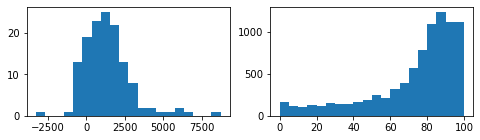

In [62]:
# TO FIGURE OUT COLORMAP CUTOFF VALUES
fig, axes = plt.subplots(1, 2, figsize = (8,2))
axes[0].hist(cts_acs['delta_tot_pop_2010-1970'], bins=20)
axes[1].hist(cbs_dec['white_alone_over_tot_pop_percent'], bins=20)

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


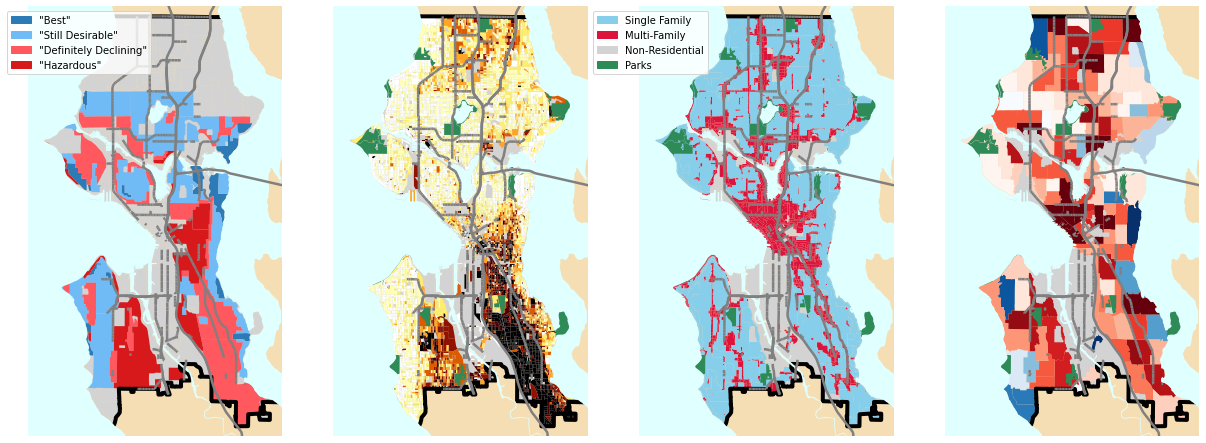

In [63]:
# MAIN PLOT
fig, axes = plt.subplots(1, 4, figsize = (21,20))

# - Redlining
zoning.plot(ax=axes[0], color='lightgray')  # background
rl.plot(column='holc_grade', ax=axes[0], color=rl['color_holc_grade'])
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/custom_legends.html
legend_elements = [Patch(color=rl_color_choices1[0], label='\"Best\"'),
                  Patch(color=rl_color_choices1[1], label='\"Still Desirable\"'),
                  Patch(color=rl_color_choices1[2], label='\"Definitely Declining\"'),
                  Patch(color=rl_color_choices1[3], label='\"Hazardous\"')]
axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.1, 1), frameon=True)
#rl.plot(column = 'two_categories', ax = axes[0], color=rl['color_two_categories'])

# - Demographics
zoning.plot(ax=axes[1], color='lightgray')  # background
cmapnow = plt.cm.get_cmap('afmhot', 8)
#cmapnow = plt.cm.get_cmap('RdBu', 8)
cbs_dec.plot(column='white_alone_over_tot_pop_percent', ax=axes[1], cmap=cmapnow, vmin=20)
#cbgs_acs.plot(column = 'white_alone_over_tot_pop', ax = axes[1])
parks.plot(ax=axes[1], color='seagreen')
#urbvill.plot(ax=axes[1], facecolor='none', edgecolor='magenta', linewidth=2)

# - Zoning
zoning.plot(column = 'simple_categories', ax=axes[2], color=zoning['color'])
legend_elements = [Patch(color=zoning_color_choices[0], label='Single Family'),
                  Patch(color=zoning_color_choices[1], label='Multi-Family'),
                  Patch(color=zoning_color_choices[2], label='Non-Residential'),
                  Patch(color='seagreen', label='Parks')]
axes[2].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.2, 1), frameon=True)
parks.plot(ax=axes[2], color='seagreen')
#urbvill.plot(ax=axes[1], facecolor='none', edgecolor='magenta', linewidth=2)

# - Pop growth
cmapnegnow = plt.cm.get_cmap('Blues_r', 8)
cmapposnow = plt.cm.get_cmap('Reds', 12)
cts_acs[cts_acs['delta_tot_pop_2010-1970']<0].plot(
    column='delta_tot_pop_2010-1970', ax=axes[3], cmap=cmapnegnow, vmin=-800, vmax=0)
cts_acs[cts_acs['delta_tot_pop_2010-1970']>=0].plot(
    column='delta_tot_pop_2010-1970', ax=axes[3], cmap=cmapposnow, vmin=0, vmax=3000)
zoning[zoning['simple_categories']=='NH'].plot(ax=axes[3], facecolor='lightgray', edgecolor='lightgray')
parks.plot(ax=axes[3], color='seagreen')

# - Prettify all subplots
for ax in axes:
    ax.set_ylim([47.49, 47.74])
    ax.set_xlim([-122.45, -122.23])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('wheat')
    seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
    #majwater.plot(ax=ax, color='paleturquoise', linewidth=3)
    majwater.plot(ax=ax, color='lightcyan', linewidth=3)
    majrds.plot(ax=ax, color='gray', linewidth=2.5)
    seards.plot(ax=ax, color='gray', linewidth=2.5)

fig.savefig('/opt/laurelhurst4all/figures/poster1.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
fig.savefig('/opt/laurelhurst4all/figures/poster1.png', dpi=300, bbox_inches='tight', pad_inches = 0)

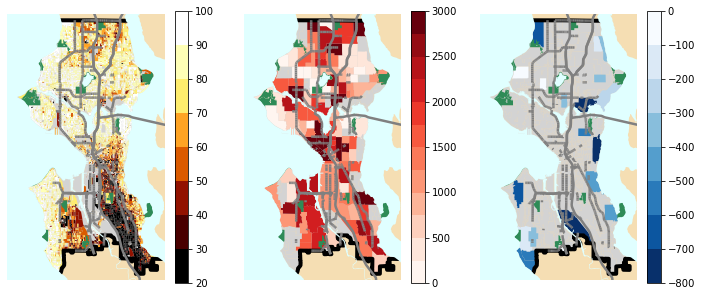

In [64]:
# FOR LEGEND PURPOSES ONLY
fig, axes = plt.subplots(1, 3, figsize = (12,5))

# - Demographics
zoning.plot(ax=axes[0], color='lightgray')  # background
cmapnow = plt.cm.get_cmap('afmhot', 8)
cbs_dec.plot(column='white_alone_over_tot_pop_percent', ax=axes[0], cmap=cmapnow, vmin=20, legend=True)
parks.plot(ax=axes[0], color='seagreen')

# - Pop growth, positive
zoning.plot(ax=axes[1], color='lightgray')  # background
cmapposnow = plt.cm.get_cmap('Reds', 12)
cts_acs[cts_acs['delta_tot_pop_2010-1970']>=0].plot(
    column='delta_tot_pop_2010-1970', ax=axes[1], cmap=cmapposnow, vmin=0, vmax=3000, legend=True)
parks.plot(ax=axes[1], color='seagreen')

# - Pop growth, negative
zoning.plot(ax=axes[2], color='lightgray')  # background
cmapnegnow = plt.cm.get_cmap('Blues_r', 8)
cts_acs[cts_acs['delta_tot_pop_2010-1970']<0].plot(
    column='delta_tot_pop_2010-1970', ax=axes[2], cmap=cmapnegnow, vmin=-800, vmax=0, legend=True)
parks.plot(ax=axes[2], color='seagreen')

# - Prettify all subplots
for ax in axes:
    ax.set_ylim([47.49, 47.74])
    ax.set_xlim([-122.45, -122.23])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('wheat')
    seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
    #majwater.plot(ax=ax, color='paleturquoise', linewidth=3)
    majwater.plot(ax=ax, color='lightcyan', linewidth=3)
    majrds.plot(ax=ax, color='gray', linewidth=2.5)
    seards.plot(ax=ax, color='gray', linewidth=2.5)
    
fig.savefig('/opt/laurelhurst4all/figures/poster1_legends.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
fig.savefig('/opt/laurelhurst4all/figures/poster1_legends.png', dpi=300, bbox_inches='tight', pad_inches = 0)

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


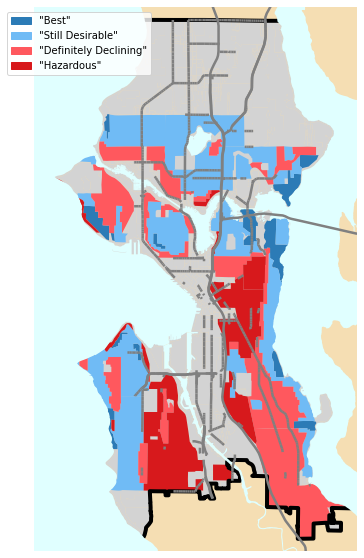

In [65]:
# MAIN PLOT MAP 1
fig, ax = plt.subplots(1, 1, figsize = (8.5,10))

# - Redlining
zoning.plot(ax=ax, color='lightgray')  # background
rl.plot(column='holc_grade', ax=ax, color=rl['color_holc_grade'])
legend_elements = [Patch(color=rl_color_choices1[0], label='\"Best\"'),
                  Patch(color=rl_color_choices1[1], label='\"Still Desirable\"'),
                  Patch(color=rl_color_choices1[2], label='\"Definitely Declining\"'),
                  Patch(color=rl_color_choices1[3], label='\"Hazardous\"')]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.1, 1), frameon=True)

# - Prettify all subplots
ax.set_ylim([47.49, 47.74])
ax.set_xlim([-122.45, -122.23])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('wheat')
seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
#majwater.plot(ax=ax, color='paleturquoise', linewidth=3)
majwater.plot(ax=ax, color='lightcyan', linewidth=3)
majrds.plot(ax=ax, color='gray', linewidth=2.5)
seards.plot(ax=ax, color='gray', linewidth=2.5)

fig.savefig('/opt/laurelhurst4all/figures/poster1_map1.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
fig.savefig('/opt/laurelhurst4all/figures/poster1_map1.png', dpi=300, bbox_inches='tight', pad_inches = 0)

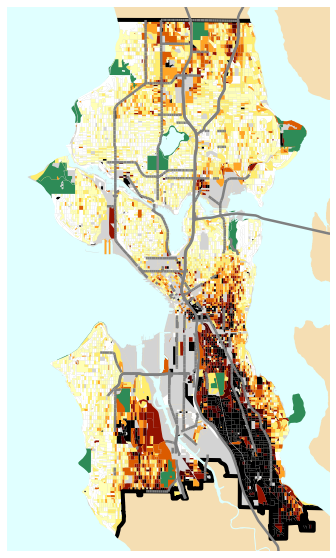

In [66]:
# MAIN PLOT MAP 2
figname = 'poster1_map2' 
#figname = 'poster1_map2_legend' 

fig, ax = plt.subplots(1, 1, figsize = (8.5,10))

# - Demographics
zoning.plot(ax=ax, color='lightgray')  # background
cmapnow = plt.cm.get_cmap('afmhot', 8)
if figname == 'poster1_map2':
    cbs_dec.plot(column='white_alone_over_tot_pop_percent', ax=ax, cmap=cmapnow, vmin=20)
elif figname == 'poster1_map2_legend':
    cbs_dec.plot(column='white_alone_over_tot_pop_percent', ax=ax, cmap=cmapnow, vmin=20, legend=True)
parks.plot(ax=ax, color='seagreen')

# - Prettify all subplots
ax.set_ylim([47.49, 47.74])
ax.set_xlim([-122.45, -122.23])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('wheat')
seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
#majwater.plot(ax=ax, color='paleturquoise', linewidth=3)
majwater.plot(ax=ax, color='lightcyan', linewidth=3)
majrds.plot(ax=ax, color='gray', linewidth=2.5)
seards.plot(ax=ax, color='gray', linewidth=2.5)

fig.savefig('/opt/laurelhurst4all/figures/' + figname + '.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
fig.savefig('/opt/laurelhurst4all/figures/' + figname + '.png', dpi=300, bbox_inches='tight', pad_inches = 0)

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


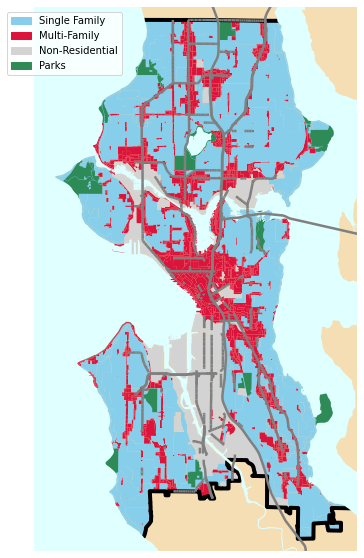

In [67]:
# MAIN PLOT MAP 3
fig, ax = plt.subplots(1, 1, figsize = (8.5,10))

# - Zoning
zoning.plot(column = 'simple_categories', ax=ax, color=zoning['color'])
legend_elements = [Patch(color=zoning_color_choices[0], label='Single Family'),
                  Patch(color=zoning_color_choices[1], label='Multi-Family'),
                  Patch(color=zoning_color_choices[2], label='Non-Residential'),
                  Patch(color='seagreen', label='Parks')]
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.1, 1), frameon=True)
parks.plot(ax=ax, color='seagreen')

# - Prettify all subplots
ax.set_ylim([47.49, 47.74])
ax.set_xlim([-122.45, -122.23])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('wheat')
seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
#majwater.plot(ax=ax, color='paleturquoise', linewidth=3)
majwater.plot(ax=ax, color='lightcyan', linewidth=3)
majrds.plot(ax=ax, color='gray', linewidth=2.5)
seards.plot(ax=ax, color='gray', linewidth=2.5)

fig.savefig('/opt/laurelhurst4all/figures/poster1_map3.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
fig.savefig('/opt/laurelhurst4all/figures/poster1_map3.png', dpi=300, bbox_inches='tight', pad_inches = 0)

In [71]:
cts_acs['centroid_unproj'] = cts_acs['geometry'].centroid

<ipython-input-71-0a22bf85bd8d>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cts_acs['centroid_unproj'] = cts_acs['geometry'].centroid


In [ ]:
# - To see fips code
fig, ax = plt.subplots(1, 1, figsize = (24,30))

cmapnegnow = plt.cm.get_cmap('Blues_r', 8)
cmapposnow = plt.cm.get_cmap('Reds', 12)
cts_acs[cts_acs['delta_tot_pop_2010-1970']<0].plot(
    column='delta_tot_pop_2010-1970', ax=ax, cmap=cmapnegnow, vmin=-800, vmax=0)
cts_acs[cts_acs['delta_tot_pop_2010-1970']>=0].plot(
    column='delta_tot_pop_2010-1970', ax=ax, cmap=cmapposnow, vmin=0, vmax=3000)
zoning[zoning['simple_categories']=='NH'].plot(ax=ax, facecolor='lightgray', edgecolor='lightgray')
parks.plot(ax=ax, color='seagreen')
for irow in range(0, len(cts_acs)): 
    ax.text(cts_acs['centroid_unproj'].iloc[irow].x-0.005, cts_acs['centroid_unproj'].iloc[irow].y,
           #np.round(cts_acs['fips'].iloc[irow]).astype(str)[0:])
           np.round(cts_acs['fips'].iloc[irow]).astype(str)[5:])
    
# - Prettify all subplots
ax.set_ylim([47.49, 47.74])
ax.set_xlim([-122.45, -122.23])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('wheat')
seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
#majwater.plot(ax=ax, color='paleturquoise', linewidth=3)
majwater.plot(ax=ax, color='lightcyan', linewidth=3)
majrds.plot(ax=ax, color='gray', linewidth=2.5)
seards.plot(ax=ax, color='gray', linewidth=2.5)

#fig.savefig('/opt/laurelhurst4all/figures/tract_fips.png', dpi=300, bbox_inches='tight', pad_inches = 0)
fig.savefig('/opt/laurelhurst4all/figures/tract_fips_no53033.png', dpi=300, bbox_inches='tight', pad_inches = 0)

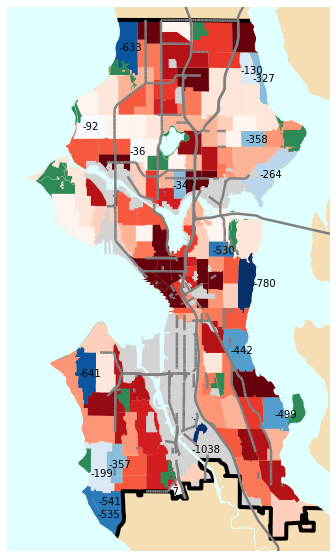

In [97]:
# MAIN PLOT MAP 4
figname = 'poster1_map4'
#figname = 'poster1_map4_legend1'
#figname = 'poster1_map4_legend2'

fig, ax = plt.subplots(1, 1, figsize = (8.5,10))

if figname == 'poster1_map4':
    # - Pop growth
    cmapnegnow = plt.cm.get_cmap('Blues_r', 8)
    cmapposnow = plt.cm.get_cmap('Reds', 12)
    cts_acs[cts_acs['delta_tot_pop_2010-1970']<0].plot(
        column='delta_tot_pop_2010-1970', ax=ax, cmap=cmapnegnow, vmin=-800, vmax=0)
    cts_acs[cts_acs['delta_tot_pop_2010-1970']>=0].plot(
        column='delta_tot_pop_2010-1970', ax=ax, cmap=cmapposnow, vmin=0, vmax=3000)
    zoning[zoning['simple_categories']=='NH'].plot(ax=ax, facecolor='lightgray', edgecolor='lightgray')
    parks.plot(ax=ax, color='seagreen')
    # - Add numbers
    cts_acsnow = cts_acs[(cts_acs['delta_tot_pop_2010-1970']<0) & (cts_acs['fips']!=53033005302)]  # exclude udist
    for irow in range(0, len(cts_acsnow)): 
        if (cts_acsnow['fips'].iloc[irow] == 53033007800):
            xshift = 0.005
        elif (cts_acsnow['fips'].iloc[irow] == 53033012000):
            xshift = -0.007
        else:
            xshift = -0.005
        if (cts_acsnow['fips'].iloc[irow] == 53033011600):
            yshift = -0.005
        elif (cts_acsnow['fips'].iloc[irow] == 53033010900):
            yshift = -0.007
        else:
            yshift = -0.002
        ax.text(cts_acsnow['centroid_unproj'].iloc[irow].x+xshift, cts_acsnow['centroid_unproj'].iloc[irow].y+yshift,
               np.round(cts_acsnow['delta_tot_pop_2010-1970'].iloc[irow]).astype(int))
    
elif figname == 'poster1_map4_legend1':
    # - Pop growth, positive
    zoning.plot(ax=ax, color='lightgray')  # background
    cmapposnow = plt.cm.get_cmap('Reds', 12)
    cts_acs[cts_acs['delta_tot_pop_2010-1970']>=0].plot(
        column='delta_tot_pop_2010-1970', ax=ax, cmap=cmapposnow, vmin=0, vmax=3000, legend=True)
    parks.plot(ax=ax, color='seagreen')

elif figname == 'poster1_map4_legend2':
    # - Pop growth, negative
    zoning.plot(ax=ax, color='lightgray')  # background
    cmapnegnow = plt.cm.get_cmap('Blues_r', 8)
    cts_acs[cts_acs['delta_tot_pop_2010-1970']<0].plot(
        column='delta_tot_pop_2010-1970', ax=ax, cmap=cmapnegnow, vmin=-800, vmax=0, legend=True)
    parks.plot(ax=ax, color='seagreen')

# - Prettify all subplots
ax.set_ylim([47.49, 47.74])
ax.set_xlim([-122.45, -122.23])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('wheat')
seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
#majwater.plot(ax=ax, color='paleturquoise', linewidth=3)
majwater.plot(ax=ax, color='lightcyan', linewidth=3)
majrds.plot(ax=ax, color='gray', linewidth=2.5)
seards.plot(ax=ax, color='gray', linewidth=2.5)

fig.savefig('/opt/laurelhurst4all/figures/' + figname + '.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
fig.savefig('/opt/laurelhurst4all/figures/' + figname + '.png', dpi=300, bbox_inches='tight', pad_inches = 0)

## Draw final figure - poster 2

<AxesSubplot:>

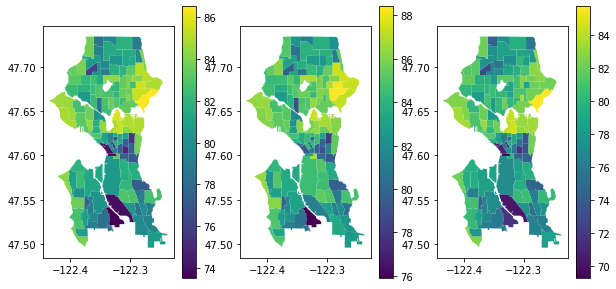

In [581]:
# TO DECIDE WHETHER TO USE MALE, FEMALE, OR BOTH LIFE SPAN
# --> use both
fig,axes = plt.subplots(1, 3, figsize = (10,5))
cts_acs.plot(column = 'life_span_both', ax = axes[0], legend=True)
cts_acs.plot(column = 'life_span_female', ax = axes[1], legend=True)
cts_acs.plot(column = 'life_span_male', ax = axes[2], legend=True)

73.5134528249972


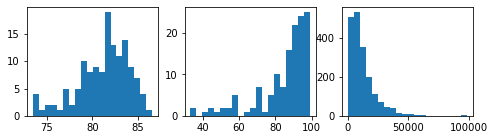

In [801]:
# TO FIGURE OUT COLORMAP CUTOFF VALUES
fig, axes = plt.subplots(1, 3, figsize = (8,2))
axes[0].hist(cts_acs['life_span_both'], bins=20)
axes[1].hist(cts_acs['veh_over_tot_hh_percent'], bins=20)
axes[2].hist(allseards['AWDT_ROUND'], bins=20)
print(cts_acs['life_span_both'].min())

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


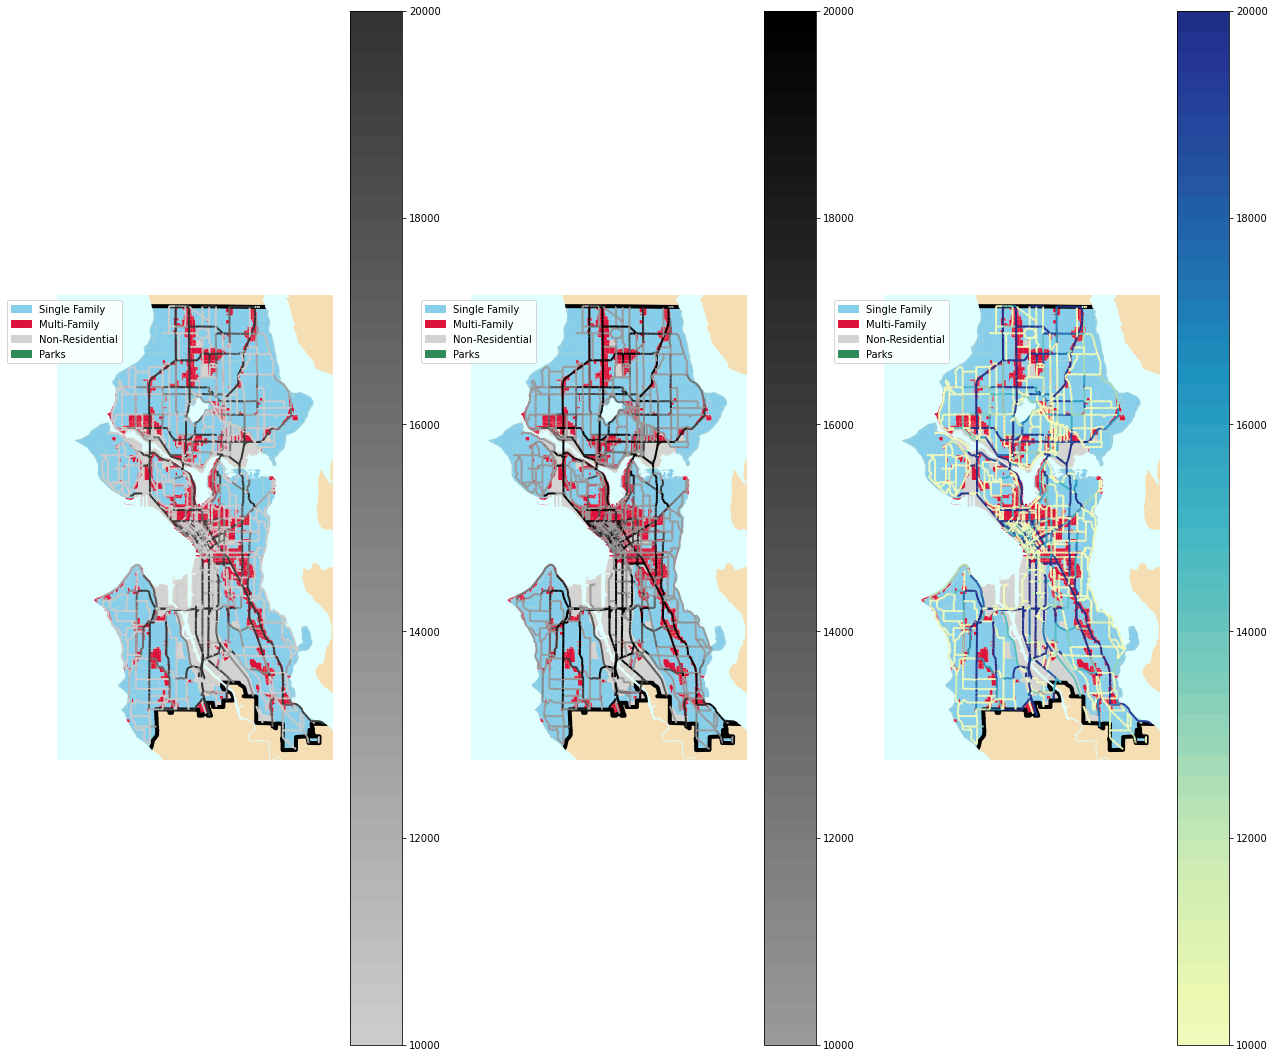

In [780]:
# TO FIGURE OUT TRAFFIC COUNT COLORMAP
fig,axes = plt.subplots(1, 3, figsize = (21,20))

# - Traffic counts + zoning in bg
zoning.plot(column = 'simple_categories', ax=axes[0], color=zoning['color'])
legend_elements = [Patch(color=zoning_color_choices[0], label='Single Family'),
                  Patch(color=zoning_color_choices[1], label='Multi-Family'),
                  Patch(color=zoning_color_choices[2], label='Non-Residential'),
                  Patch(color='seagreen', label='Parks')]
axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.2, 1), frameon=True)
#cmapnow = plt.cm.get_cmap('YlGnBu', 50)
cmapnow = cmr.get_sub_cmap('gray_r', 0.2, 0.8, N=50)
#cmapnow = plt.cm.get_cmap('cool', 10)
#cmapnow = plt.cm.get_cmap('winter_r', 20)
#cmapnow = plt.cm.get_cmap('bone', 50)  # pretty good
#cmapnow = plt.cm.get_cmap('YlOrBr_r', 50)  # pretty good
#cmapnow = plt.cm.get_cmap('Blues_r', 50)  # pretty good
#cmapnow = plt.cm.get_cmap('viridis', 50)
#cmapnow = plt.cm.get_cmap('inferno', 50)
#cmapnow = plt.cm.get_cmap('plasma', 50)
#cmapnow = cmr.get_sub_cmap('YlGnBu_r', 0.5, 0.95, N=50)
#cmapnow = cmr.get_sub_cmap('GnBu_r', 0.4, 1, N=50)
#cmapnow = cmr.get_sub_cmap('YlGn_r', 0, 1, N=50)
#cmapnow = cmr.get_sub_cmap('copper_r', 0.2, 1, N=50)
allseards.plot(column='AWDT', ax=axes[0], cmap=cmapnow, linewidth=2, vmin=10000, vmax=20000, legend=True)
#parks.plot(ax=axes[0], color='seagreen')

# - Traffic counts + zoning in bg
zoning.plot(column = 'simple_categories', ax=axes[1], color=zoning['color'])
legend_elements = [Patch(color=zoning_color_choices[0], label='Single Family'),
                  Patch(color=zoning_color_choices[1], label='Multi-Family'),
                  Patch(color=zoning_color_choices[2], label='Non-Residential'),
                  Patch(color='seagreen', label='Parks')]
axes[1].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.2, 1), frameon=True)
cmapnow = cmr.get_sub_cmap('gray_r', 0.4, 1, N=50)
#cmapnow = cmr.get_sub_cmap('YlGnBu_r', 0.4, 1, N=50)
allseards.plot(column='AWDT', ax=axes[1], cmap=cmapnow, linewidth=2, vmin=10000, vmax=20000, legend=True)
#parks.plot(ax=axes[1], color='seagreen')

# - Traffic counts + zoning in bg
zoning.plot(column = 'simple_categories', ax=axes[2], color=zoning['color'])
legend_elements = [Patch(color=zoning_color_choices[0], label='Single Family'),
                  Patch(color=zoning_color_choices[1], label='Multi-Family'),
                  Patch(color=zoning_color_choices[2], label='Non-Residential'),
                  Patch(color='seagreen', label='Parks')]
axes[2].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.2, 1), frameon=True)
#cmapnow = cmr.get_sub_cmap('bone', 0.6, 1, N=50)
cmapnow = cmr.get_sub_cmap('YlGnBu', 0.1, 0.9, N=50)
#cmapnow = cmr.get_sub_cmap('YlGnBu_r', 0.45, 1, N=50)
allseards.plot(column='AWDT', ax=axes[2], cmap=cmapnow, linewidth=2, vmin=10000, vmax=20000, legend=True)
#parks.plot(ax=axes[2], color='seagreen')

# - Prettify all subplots
for ax in axes:
    ax.set_ylim([47.49, 47.74])
    ax.set_xlim([-122.45, -122.23])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('wheat')
    seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
    #majwater.plot(ax=ax, color='paleturquoise', linewidth=3)
    majwater.plot(ax=ax, color='lightcyan', linewidth=3)
    #majrds.plot(ax=ax, color='gray', linewidth=2.5)
    #seards.plot(ax=ax, color='gray', linewidth=2.5)

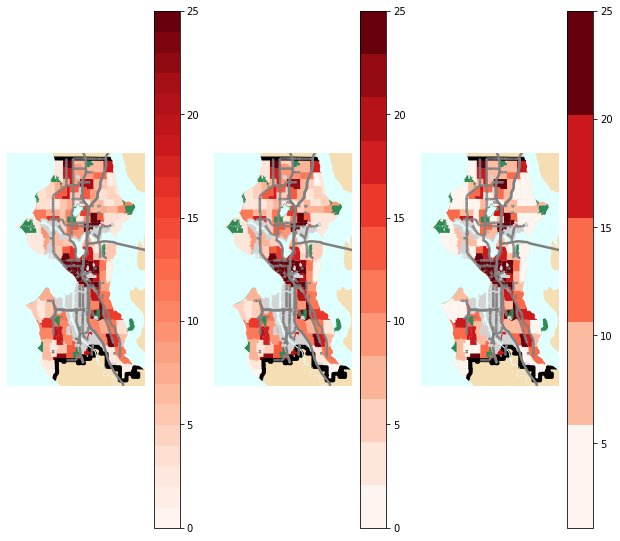

In [682]:
# TO FIGURE OUT CAR OWNERSHIP COLORMAP
fig,axes = plt.subplots(1, 3, figsize = (10.5,10))

# - Car ownership
cmapnow = plt.cm.get_cmap('Reds', 25)
cts_acs.plot(column = 'no_veh_over_tot_hh_percent', ax = axes[0], cmap=cmapnow, vmin=0, vmax=25, legend=True)
zoning[zoning['simple_categories']=='NH'].plot(ax=axes[0], facecolor='lightgray', edgecolor='lightgray')
parks.plot(ax=axes[0], color='seagreen')
majrds.plot(ax=axes[0], color='gray', linewidth=2.5)
seards.plot(ax=axes[0], color='gray', linewidth=2.5)

# - Car ownership
cmapnow = plt.cm.get_cmap('Reds', 12)
cts_acs.plot(column = 'no_veh_over_tot_hh_percent', ax = axes[1], cmap=cmapnow, vmin=0, vmax=25, legend=True)
zoning[zoning['simple_categories']=='NH'].plot(ax=axes[1], facecolor='lightgray', edgecolor='lightgray')
parks.plot(ax=axes[1], color='seagreen')
majrds.plot(ax=axes[1], color='gray', linewidth=2.5)
seards.plot(ax=axes[1], color='gray', linewidth=2.5)

# - Car ownership
cmapnow = plt.cm.get_cmap('Reds', 5)
cts_acs.plot(column = 'no_veh_over_tot_hh_percent', ax = axes[2], cmap=cmapnow, vmax=25, legend=True)
zoning[zoning['simple_categories']=='NH'].plot(ax=axes[2], facecolor='lightgray', edgecolor='lightgray')
parks.plot(ax=axes[2], color='seagreen')
majrds.plot(ax=axes[2], color='gray', linewidth=2.5)
seards.plot(ax=axes[2], color='gray', linewidth=2.5)

# - Prettify all subplots
for ax in axes:
    ax.set_ylim([47.49, 47.74])
    ax.set_xlim([-122.45, -122.23])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('wheat')
    seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
    majwater.plot(ax=ax, color='lightcyan', linewidth=3)

#fig.savefig('/opt/dssg-hot/notebooks/shirley/figs/' + pdfnamenow + '.pdf', bbox_inches='tight', pad_inches = 0)

### Run these before main plots

In [99]:
allseards['AWDT_thousands'] = allseards['AWDT']/1000
cts_acs['veh_over_tot_hh_percent'] = 100 * (1-cts_acs['no_veh_over_tot_hh'])

In [100]:
zoning = gpd.read_file('/opt/laurelhurst4all/data/shapefiles/zoning/Land_Use_Zoning_Detail_with_Capacity_Assumptions.shp')
zoning = zoning[['CLASS_DESC', 'geometry']]
zoning_conditions = [
    (zoning['CLASS_DESC'] == 'Single Family'),
    (zoning['CLASS_DESC'] == 'Multi-Family') | (zoning['CLASS_DESC'] == 'Commercial/Mixed Use') |
        (zoning['CLASS_DESC'] == 'Master Planned Community') | (zoning['CLASS_DESC'] == 'Downtown'),
    (zoning['CLASS_DESC'] == 'Manufacturing/Industrial') | (zoning['CLASS_DESC'] == 'Major Institutions')]
zoning_choices = ['SF', 'MF/MU', 'NH']
zoning['simple_categories'] = np.select(zoning_conditions, zoning_choices, default='OTHER')
#zoning_color_choices = ['#377eb8', '#e41a1c', 'lightgray']
#zoning_color_choices = ['#70BBF5', '#FF585E', 'lightgray']
#zoning_color_choices = ['cornflowerblue', 'indianred', 'gainsboro']
#zoning_color_choices = ['#80b1d3', '#fb8072', 'lightgray']
#zoning_color_choices = ['skyblue', 'crimson', 'lightgray']
zoning_color_choices = ['skyblue', 'crimson', 'linen']
zoning['color'] = np.select(zoning_conditions, zoning_color_choices, default='linen')
#zoning.plot()

### Make plots

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


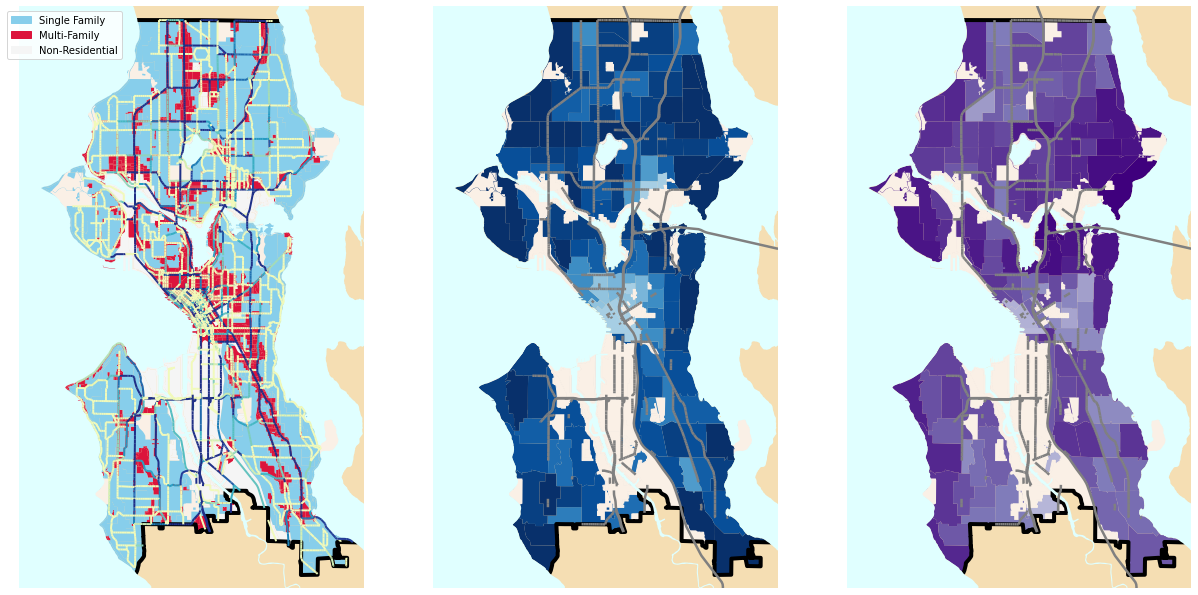

In [812]:
# MAIN PLOT
fig,axes = plt.subplots(1, 3, figsize = (21,20))

# - Traffic counts + zoning in bg
zoning.plot(column = 'simple_categories', ax=axes[0], color=zoning['color'])
legend_elements = [Patch(color=zoning_color_choices[0], label='Single Family'),
                  Patch(color=zoning_color_choices[1], label='Multi-Family'),
                  Patch(color=zoning_color_choices[2], label='Non-Residential')]
                  # , Patch(color='seagreen', label='Parks')]
axes[0].legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(-0.05, 1), frameon=True)
cmapnow = cmr.get_sub_cmap('YlGnBu', 0.1, 0.9, N=50)
allseards.plot(column='AWDT_thousands', ax=axes[0], cmap=cmapnow, linewidth=2, vmin=10, vmax=20)
parks.plot(ax=axes[0], color='linen')

# - Car ownership
cmapnow = cmr.get_sub_cmap('Blues', 0.35, 1, N=12)
cts_acs.plot(column = 'veh_over_tot_hh_percent', ax = axes[1], cmap=cmapnow, vmin=50)
zoning[zoning['simple_categories']=='NH'].plot(ax=axes[1], facecolor='linen', edgecolor='linen')
parks.plot(ax=axes[1], color='linen')
majrds.plot(ax=axes[1], color='gray', linewidth=2.5)
seards.plot(ax=axes[1], color='gray', linewidth=2.5)

# - Life span
cmapnow = cmr.get_sub_cmap('Purples', 0.4, 1, N=30)
cts_acs.plot(column = 'life_span_both', ax = axes[2], cmap=cmapnow)
zoning[zoning['simple_categories']=='NH'].plot(ax=axes[2], facecolor='linen', edgecolor='linen')
parks.plot(ax=axes[2], color='linen')
majrds.plot(ax=axes[2], color='gray', linewidth=2.5)
seards.plot(ax=axes[2], color='gray', linewidth=2.5)

# - Prettify all subplots
for ax in axes:
    ax.set_ylim([47.49, 47.74])
    ax.set_xlim([-122.45, -122.23])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('wheat')
    seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
    majwater.plot(ax=ax, color='lightcyan', linewidth=3)

fig.savefig('/opt/laurelhurst4all/figures/poster2.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
fig.savefig('/opt/laurelhurst4all/figures/poster2.png', dpi=300, bbox_inches='tight', pad_inches = 0)

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


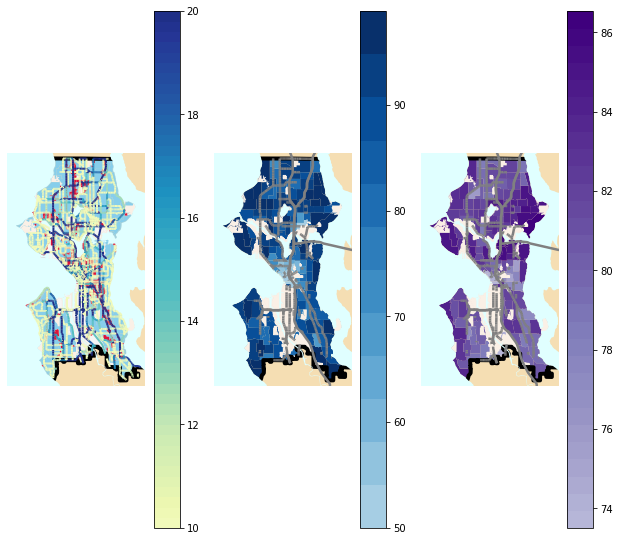

In [811]:
# FOR LEGEND PURPOSES ONLY
fig,axes = plt.subplots(1, 3, figsize = (10.5,10))

# - Traffic counts + zoning in bg
zoning.plot(column = 'simple_categories', ax=axes[0], color=zoning['color'])
cmapnow = cmr.get_sub_cmap('YlGnBu', 0.1, 0.9, N=50)
allseards.plot(column='AWDT_thousands', ax=axes[0], cmap=cmapnow, linewidth=2, vmin=10, vmax=20, legend=True)
parks.plot(ax=axes[0], color='linen')

# - Car ownership
cmapnow = cmr.get_sub_cmap('Blues', 0.35, 1, N=12)
cts_acs.plot(column = 'veh_over_tot_hh_percent', ax = axes[1], cmap=cmapnow, vmin=50, legend=True)
zoning[zoning['simple_categories']=='NH'].plot(ax=axes[1], facecolor='linen', edgecolor='linen')
parks.plot(ax=axes[1], color='linen')
majrds.plot(ax=axes[1], color='gray', linewidth=2.5)
seards.plot(ax=axes[1], color='gray', linewidth=2.5)

# - Life span
cmapnow = cmr.get_sub_cmap('Purples', 0.4, 1, N=30)
cts_acs.plot(column = 'life_span_both', ax = axes[2], cmap=cmapnow, legend=True)
zoning[zoning['simple_categories']=='NH'].plot(ax=axes[2], facecolor='linen', edgecolor='linen')
parks.plot(ax=axes[2], color='linen')
majrds.plot(ax=axes[2], color='gray', linewidth=2.5)
seards.plot(ax=axes[2], color='gray', linewidth=2.5)

# - Prettify all subplots
for ax in axes:
    ax.set_ylim([47.49, 47.74])
    ax.set_xlim([-122.45, -122.23])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)    
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('wheat')
    seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
    majwater.plot(ax=ax, color='lightcyan', linewidth=3)

fig.savefig('/opt/laurelhurst4all/figures/poster2_legends.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
fig.savefig('/opt/laurelhurst4all/figures/poster2_legends.png', dpi=300, bbox_inches='tight', pad_inches = 0)

/opt/conda/lib/python3.8/site-packages/geopandas/plotting.py:572: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


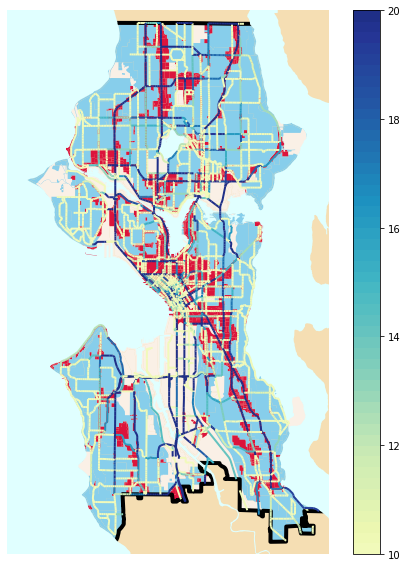

In [92]:
# MAIN PLOT MAP 1
fig,ax = plt.subplots(1, 1, figsize = (8.5,10))

# - Traffic counts + zoning in bg
zoning.plot(column = 'simple_categories', ax=ax, color=zoning['color'])
cmapnow = cmr.get_sub_cmap('YlGnBu', 0.1, 0.9, N=50)
allseards.plot(column='AWDT_thousands', ax=ax, cmap=cmapnow, linewidth=2, vmin=10, vmax=20, legend=True)
parks.plot(ax=ax, color='linen')

# - Prettify all subplots
ax.set_ylim([47.49, 47.74])
ax.set_xlim([-122.45, -122.23])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('wheat')
seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
majwater.plot(ax=ax, color='lightcyan', linewidth=3)

fig.savefig('/opt/laurelhurst4all/figures/poster2_map1.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
fig.savefig('/opt/laurelhurst4all/figures/poster2_map1.png', dpi=300, bbox_inches='tight', pad_inches = 0)

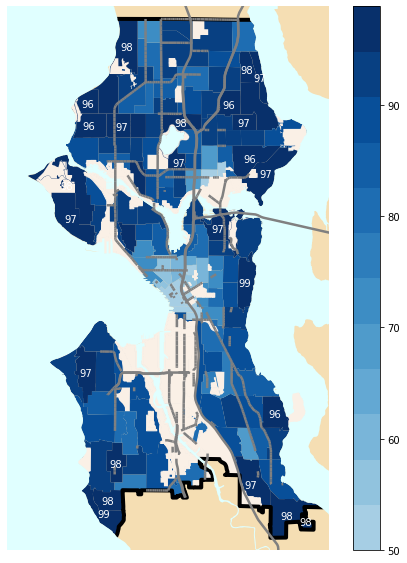

In [123]:
# MAIN PLOT MAP 2
fig,ax = plt.subplots(1, 1, figsize = (8.5,10))

# - Car ownership
cmapnow = cmr.get_sub_cmap('Blues', 0.35, 1, N=12)
cts_acs.plot(column = 'veh_over_tot_hh_percent', ax = ax, cmap=cmapnow, vmin=50, legend=True)
zoning[zoning['simple_categories']=='NH'].plot(ax=ax, facecolor='linen', edgecolor='linen')
parks.plot(ax=ax, color='linen')
majrds.plot(ax=ax, color='gray', linewidth=2.5)
seards.plot(ax=ax, color='gray', linewidth=2.5)

# - Add numbers
cts_acsnow = cts_acs[cts_acs['veh_over_tot_hh_percent']>=96]
for irow in range(0, len(cts_acsnow)): 
    if (cts_acsnow['fips'].iloc[irow] == 53033000900):
        xshift = -0.004
    elif (cts_acsnow['fips'].iloc[irow] == 53033003000):
        xshift = -0.002
    elif (cts_acsnow['fips'].iloc[irow] == 53033004600):
        xshift = 0
    elif (cts_acsnow['fips'].iloc[irow] == 53033006200):
        xshift = -0.009
    elif (cts_acsnow['fips'].iloc[irow] == 53033010200):
        xshift = -0.009
    else:
        xshift = -0.005
    if (cts_acsnow['fips'].iloc[irow] == 53033004600):
        yshift = -0.005
    else:
        yshift = -0.002
    ax.text(cts_acsnow['centroid_unproj'].iloc[irow].x+xshift, cts_acsnow['centroid_unproj'].iloc[irow].y+yshift,
           np.round(cts_acsnow['veh_over_tot_hh_percent'].iloc[irow]).astype(int), color='white')
           #np.around(cts_acsnow['veh_over_tot_hh_percent'].iloc[irow], decimals=1), color='gray')
    
# - Prettify all subplots
ax.set_ylim([47.49, 47.74])
ax.set_xlim([-122.45, -122.23])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('wheat')
seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
majwater.plot(ax=ax, color='lightcyan', linewidth=3)

fig.savefig('/opt/laurelhurst4all/figures/poster2_map2.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
fig.savefig('/opt/laurelhurst4all/figures/poster2_map2.png', dpi=300, bbox_inches='tight', pad_inches = 0)

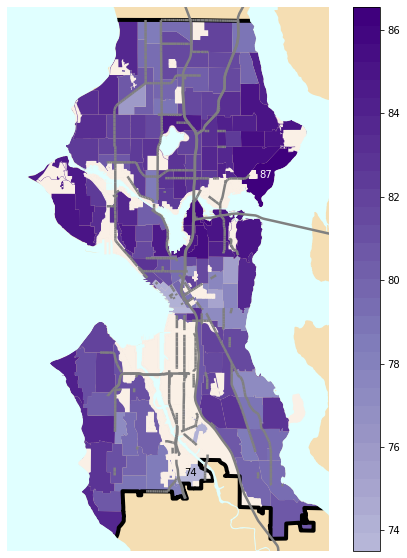

In [131]:
# MAIN PLOT MAP 3
fig,ax = plt.subplots(1, 1, figsize = (8.5,10))

# - Life span
cmapnow = cmr.get_sub_cmap('Purples', 0.4, 1, N=30)
cts_acs.plot(column = 'life_span_both', ax = ax, cmap=cmapnow, legend=True)
zoning[zoning['simple_categories']=='NH'].plot(ax=ax, facecolor='linen', edgecolor='linen')
parks.plot(ax=ax, color='linen')
majrds.plot(ax=ax, color='gray', linewidth=2.5)
seards.plot(ax=ax, color='gray', linewidth=2.5)

# - Add numbers
cts_acsnow = cts_acs[cts_acs['life_span_both']==cts_acs['life_span_both'].max()]
for irow in range(0, len(cts_acsnow)): 
    xshift = -0.005
    yshift = -0.002
    ax.text(cts_acsnow['centroid_unproj'].iloc[irow].x+xshift, cts_acsnow['centroid_unproj'].iloc[irow].y+yshift,
           np.round(cts_acsnow['life_span_both'].iloc[irow]).astype(int), color='white')
           #np.around(cts_acsnow['life_span_both'].iloc[irow], decimals=1), color='white')
cts_acsnow = cts_acs[cts_acs['life_span_both']==cts_acs['life_span_both'].min()]
for irow in range(0, len(cts_acsnow)): 
    xshift = -0.003
    yshift = -0.004
    ax.text(cts_acsnow['centroid_unproj'].iloc[irow].x+xshift, cts_acsnow['centroid_unproj'].iloc[irow].y+yshift,
           np.round(cts_acsnow['life_span_both'].iloc[irow]).astype(int), color='black')
           #np.around(cts_acsnow['life_span_both'].iloc[irow], decimals=1), color='black')

# - Prettify all subplots
ax.set_ylim([47.49, 47.74])
ax.set_xlim([-122.45, -122.23])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_facecolor('wheat')
seabdr.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=4)
majwater.plot(ax=ax, color='lightcyan', linewidth=3)

fig.savefig('/opt/laurelhurst4all/figures/poster2_map3.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
fig.savefig('/opt/laurelhurst4all/figures/poster2_map3.png', dpi=300, bbox_inches='tight', pad_inches = 0)

## Draw final figure - poster 3

In [ ]:
fig,axes = plt.subplots(1, 3, figsize = (10.5,10))

#barchart

#fig.savefig('/opt/laurelhurst4all/figures/poster3.pdf', dpi=300, bbox_inches='tight', pad_inches = 0)
#fig.savefig('/opt/laurelhurst4all/figures/poster3.png', dpi=300, bbox_inches='tight', pad_inches = 0)

# EXTRAS

In [62]:
# seattle fips = 5363000
# white_alone = c.sf1.state_place(('NAME', 'B02001_002E'), states.WA.fips, Census.ALL)

In [ ]:
c.acs5.state_county_tract(('NAME', 'B02001_002E'), states.WA.fips, '033', Census.ALL)

In [ ]:
c.acs5.get(('NAME', 'B02001_002E'),
           geo={'for': 'tract:*', 'in': 'state:53 county:033'})

In [ ]:
c.acs5.get(('NAME', 'B02001_002E'),
           geo={'for': 'tract:*', 'in': 'state:{} county:033'.format(states.WA.fips)})

In [ ]:
c.acs5.tables()